## Neural network training notebook: generalized surrogate model based on ATC-138
### Hazard level: any, impeding factors OFF
Train, evaluate, and optimize in one notebook.
Omar Issa, Stanford University (Spring 2022)

In [82]:
# Import packages
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, explained_variance_score,r2_score
import pickle
import time
import copy
import random
import seaborn as sns
font = {'fontname':'Source sans pro'}


## Read and manipulate data
Extract random and edge cases from CSV files.

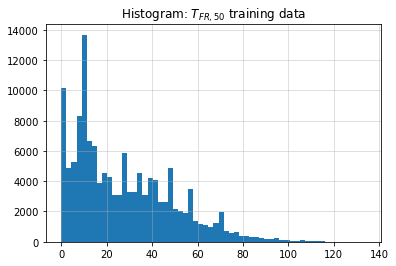

In [83]:
# Settings
pTrain = 0.80
pValidate = 0.10
pTest = 0.10

#Load data from file
df_random     = pd.read_csv('random_set.csv', header = None)
df_uniform    = pd.read_csv('uniform.csv', header = None)
df_baseline   = pd.read_csv('baseline.csv', header = None)
df_comp       = pd.read_csv('comp.csv', header = None)

df_random_sys = pd.read_csv('rand_sys.csv', header = None)


flag = 1 # 1 trained on all data, 2 on random data, and 3 on edge cases

if flag == 1:
        data = np.concatenate((df_random.to_numpy(),df_uniform.to_numpy(),df_baseline.to_numpy(),df_comp.to_numpy(),df_random_sys.to_numpy()))
        data = np.delete(data, np.where(data == 540)[0], axis=0)

if flag == 2:
        data = df_random.to_numpy()

# Shuffle data        
np.random.shuffle(data)
# data = np.concatenate((df_edge.to_numpy(),data))

# Definition of inputs and outputs
size_data = data.shape

input_data = data[:,:(size_data[1]-1)]
output_data = data[:,-1]

edge_data = np.concatenate((df_uniform.to_numpy(),df_baseline.to_numpy(),df_comp.to_numpy(),df_random_sys.to_numpy()))
edge_data       = np.delete(edge_data, np.where(edge_data == 540)[0], axis=0)
edge_data_input = edge_data[:,:(size_data[1]-1)]
edge_data_label = edge_data[:,-1]

non_edge_data = df_random.to_numpy()
non_edge_data   = np.delete(non_edge_data, np.where(non_edge_data == 540)[0], axis=0)
non_edge_data_input = non_edge_data[:,:(size_data[1]-1)]
non_edge_data_label = non_edge_data[:,-1]

# Normal standarization of data 
scaler = StandardScaler()
scaler.fit(input_data)

# Plot distribution of output_data
plt.hist(output_data, bins=60)
plt.title('Histogram: $T_{FR,50}$ training data')
plt.grid(alpha = 0.5)
plt.show()

In [84]:
# Store the "transform" (mus, sigmas) in a pickle, to be applied to the data later
with open('scaler_nn1.pkl', 'wb') as f:
        pickle.dump(scaler, f)

input_data = scaler.transform(input_data)
edge_data_input = scaler.transform(edge_data_input)
non_edge_data_input = scaler.transform(non_edge_data_input)

# Split into training, validation and testing set
# p1 and p2 are thresholds to which the data is divided

# DATA MUST BE SHUFFLED
p1 = int(size_data[0]*pTrain) # train
train_data = input_data[:p1,:]
train_label = output_data[:p1]

p2 = int(size_data[0]*(pTrain+pValidate)) # validate and test
valid_data = input_data[p1:p2,:]
valid_label = output_data[p1:p2]
test_data = input_data[p2:,:]
test_label = output_data[p2:]

## Train model

In [85]:
# Training model. We're using scikit-learn since it works well with Numpy
# Hyperparameters that we found are entered.
mlp = MLPRegressor(hidden_layer_sizes=3*(150,), learning_rate_init=0.0003,  tol = 1e-4, max_iter=800, alpha=0.0001, verbose = True)
mlp.fit(train_data, train_label)
print('Model Fitted')
#Saving model for posteriority
#
with open('model_fitted_nn_v1.pkl', 'wb') as f:
        pickle.dump(mlp, f)

Iteration 1, loss = 76.19636716
Iteration 2, loss = 14.01628317
Iteration 3, loss = 7.66046949
Iteration 4, loss = 5.11347504
Iteration 5, loss = 4.10029323
Iteration 6, loss = 3.50798056
Iteration 7, loss = 3.10978259
Iteration 8, loss = 2.80978450
Iteration 9, loss = 2.58475612
Iteration 10, loss = 2.38601255
Iteration 11, loss = 2.21494253
Iteration 12, loss = 2.05015073
Iteration 13, loss = 1.92990449
Iteration 14, loss = 1.78538046
Iteration 15, loss = 1.68945695
Iteration 16, loss = 1.58379203
Iteration 17, loss = 1.49790632
Iteration 18, loss = 1.42811847
Iteration 19, loss = 1.36451604
Iteration 20, loss = 1.29836670
Iteration 21, loss = 1.25018585
Iteration 22, loss = 1.20047062
Iteration 23, loss = 1.15864714
Iteration 24, loss = 1.11988806
Iteration 25, loss = 1.09031109
Iteration 26, loss = 1.05432560
Iteration 27, loss = 1.01619587
Iteration 28, loss = 0.98476391
Iteration 29, loss = 0.95453188
Iteration 30, loss = 0.93163738
Iteration 31, loss = 0.89589011
Iteration 32, l

## Load the saved model

In [86]:
#Load saved model so we don't need to train everytime

mlp = pickle.load(open('model_fitted_nn_v1.pkl','rb'))

# Computing values predicted by the neural network

nn_train_label = mlp.predict(train_data)
nn_test_label = mlp.predict(test_data)

nn_edge_label = mlp.predict(edge_data_input)
nn_non_edge_label = mlp.predict(non_edge_data_input)


#Computing R2 error
r2_train = r2_score(train_label,nn_train_label)
r2_test = r2_score(test_label,nn_test_label)
r2_edge = r2_score(edge_data_label,nn_edge_label)
r2_non_edge = r2_score(non_edge_data_label,nn_non_edge_label)
#plotting scatter plot of NN vs Label


#Printing accuracy values
print('R2 train data')
print(r2_train)

print('R2 test data')
print(r2_test)

print('R2 edge data')
print(r2_edge)

print('R2 non-edge data')
print(r2_non_edge)


R2 train data
0.9995979473081124
R2 test data
0.9986922433112315
R2 edge data
0.9997881044383499
R2 non-edge data
0.9991574129570974


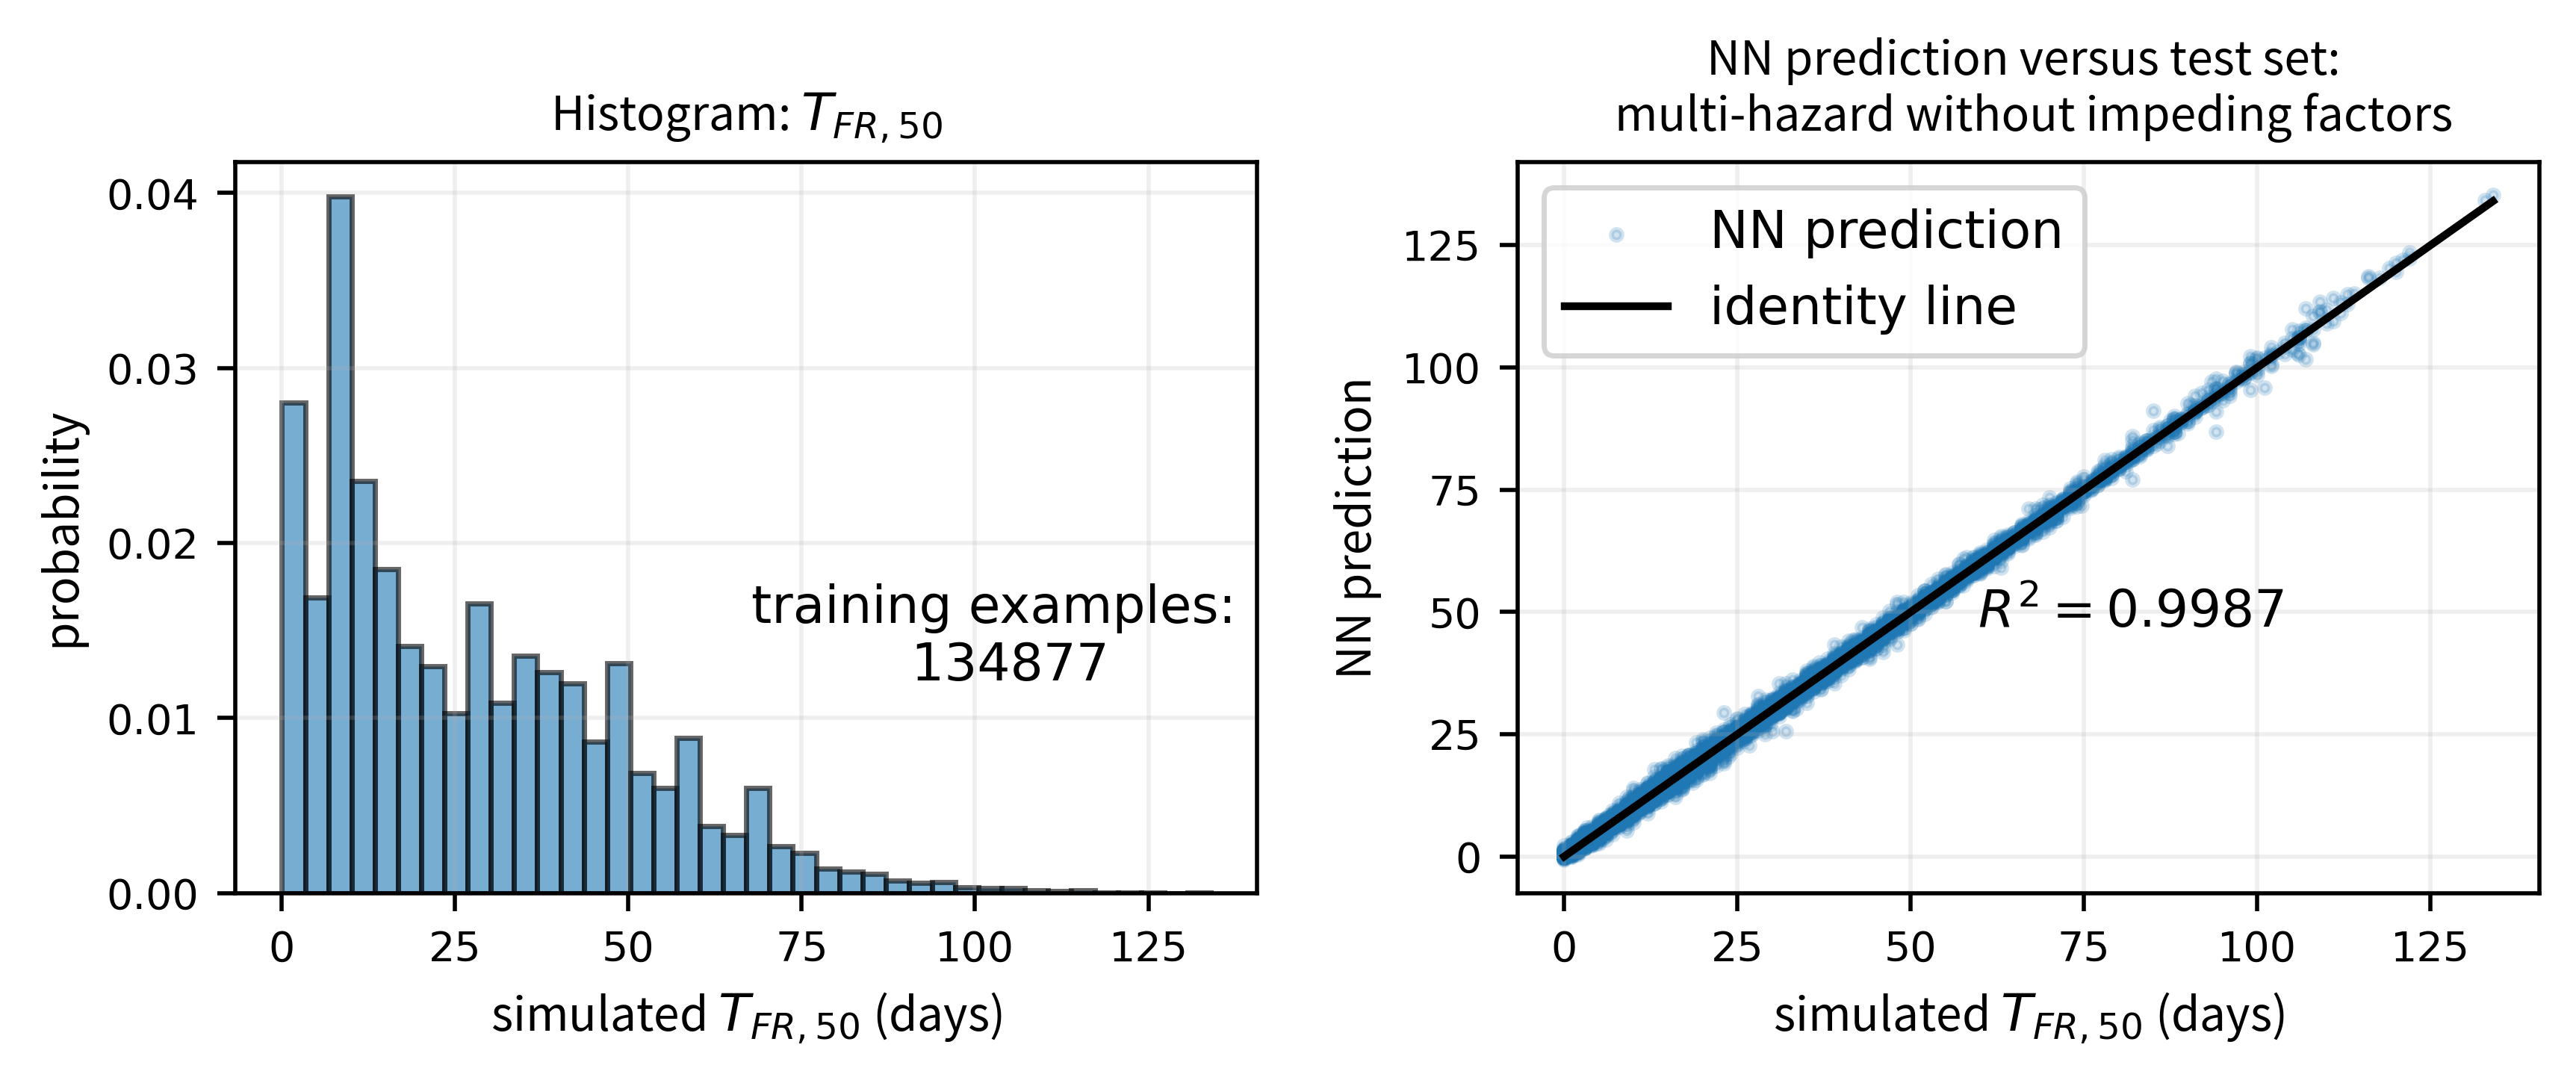

In [87]:
# Create summary dashboard

plt.figure(figsize=(7,3), dpi=500) 

ax1 = plt.subplot(1,2,1)
plt.hist(output_data, bins=40, histtype='bar', ec='black', density=True, alpha=0.6)
plt.title('Histogram: $T_{FR,50}$', fontsize=10, **font)          
plt.xlabel('simulated $T_{FR,50}$ (days)', **font) 
plt.ylabel('probability', **font) 
plt.grid(alpha = 0.2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(0.75,0.35,'training examples: \n {}'.format(str(size_data[0])), horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes)


ax2 = plt.subplot(1,2,2)
plt.scatter(test_label,nn_test_label,s=4, label = "NN prediction",alpha=0.2)
plt.plot([0,np.max(test_label)],[0,np.max(test_label)],color = 'k', label = "identity line")
plt.xlabel('simulated $T_{FR,50}$ (days)', **font)
plt.ylabel('NN prediction', **font)
plt.title('NN prediction versus test set: \n multi-hazard without impeding factors', fontsize=10, **font) 
plt.grid(alpha=0.2)
plt.text(0.75,0.35,'$R^2 = {}$'.format(str(np.round(r2_test,4))),horizontalalignment='right', verticalalignment='bottom', transform = ax2.transAxes, **font) 
plt.legend()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


plt.savefig("myimg.svg")





## Extract NN OCAT results at user-defined EDP intensity

In [72]:
'''Perform sensitivity analysis'''
n_component = 41
n_increases = 36

t0 = time.time()

sens_matrix = np.zeros((n_component,n_increases))

''' Example discussed while teaching how to use the code'''
edp_input = np.array([[0.0180361, 0.01825795, 0.01739635, 223.101, 325.643, 351.9045, 408.205]])
input_to_evaluate = np.concatenate((edp_input, np.ones((1,41))), axis = 1)
# input_to_evaluate[4] = 2.5
input_to_evaluate = scaler.transform(input_to_evaluate)
output_value = mlp.predict(input_to_evaluate)

for i in range(n_component):
        for j in range(n_increases):
                vector_input = np.ones((1,n_component))
                vector_input[0][i] = 0.5 + j*0.1
                full = np.concatenate((edp_input, vector_input), axis = 1)
                vector_input = scaler.transform(full)
                pred_val = mlp.predict(vector_input)
                sens_matrix[i][j] = pred_val[0]
t1 = time.time()

print(t1-t0)

with open('sensitivity_matrix.pkl','wb') as f:
        pickle.dump(sens_matrix,f)

np.savetxt('sensitivity_matrix.csv',sens_matrix,delimiter=',')


0.14491009712219238


In [73]:
sens_matrix

array([[34.72721253, 34.9828647 , 35.28224032, ..., 34.97333736,
        35.02417686, 35.06710749],
       [38.37679597, 36.89289679, 35.64120541, ..., 36.18276853,
        36.20124324, 36.21179945],
       [42.20499138, 39.55152381, 37.41020541, ..., 34.70235621,
        34.71568411, 34.72901202],
       ...,
       [35.19062198, 35.16941509, 35.15289041, ..., 35.10542099,
        35.12357544, 35.14172989],
       [35.14596096, 35.13974373, 35.13294792, ..., 35.21649466,
        35.23069062, 35.24577689],
       [35.06635846, 35.07786383, 35.09378974, ..., 35.38877037,
        35.41284008, 35.42883483]])

## Plot OCAT component dashboard: NN versus ATC-138 simulation at user-defined EDP intensity

In [74]:
# Extract the one at a time analysis from file to see how the two compare

df_sim_OAAT = pd.read_csv('edge_medEDP_OCAT_475_0.csv', header = None)
data_sim_OAAT = df_sim_OAAT.to_numpy()

n_component = 41
n_increases = 36

#preallocate memory for OAAT matrix
sens_matrix_sim = np.zeros((n_component,n_increases))

for i in range(data_sim_OAAT.shape[0]):
    comp_idx = int(np.floor(i/n_increases))
    cap_idx = int(np.mod(i, n_increases))
    sens_matrix_sim[comp_idx, cap_idx] = data_sim_OAAT[i,-1]    


np.savetxt('sensitivity_matrix_sim.csv',sens_matrix_sim,delimiter=',')



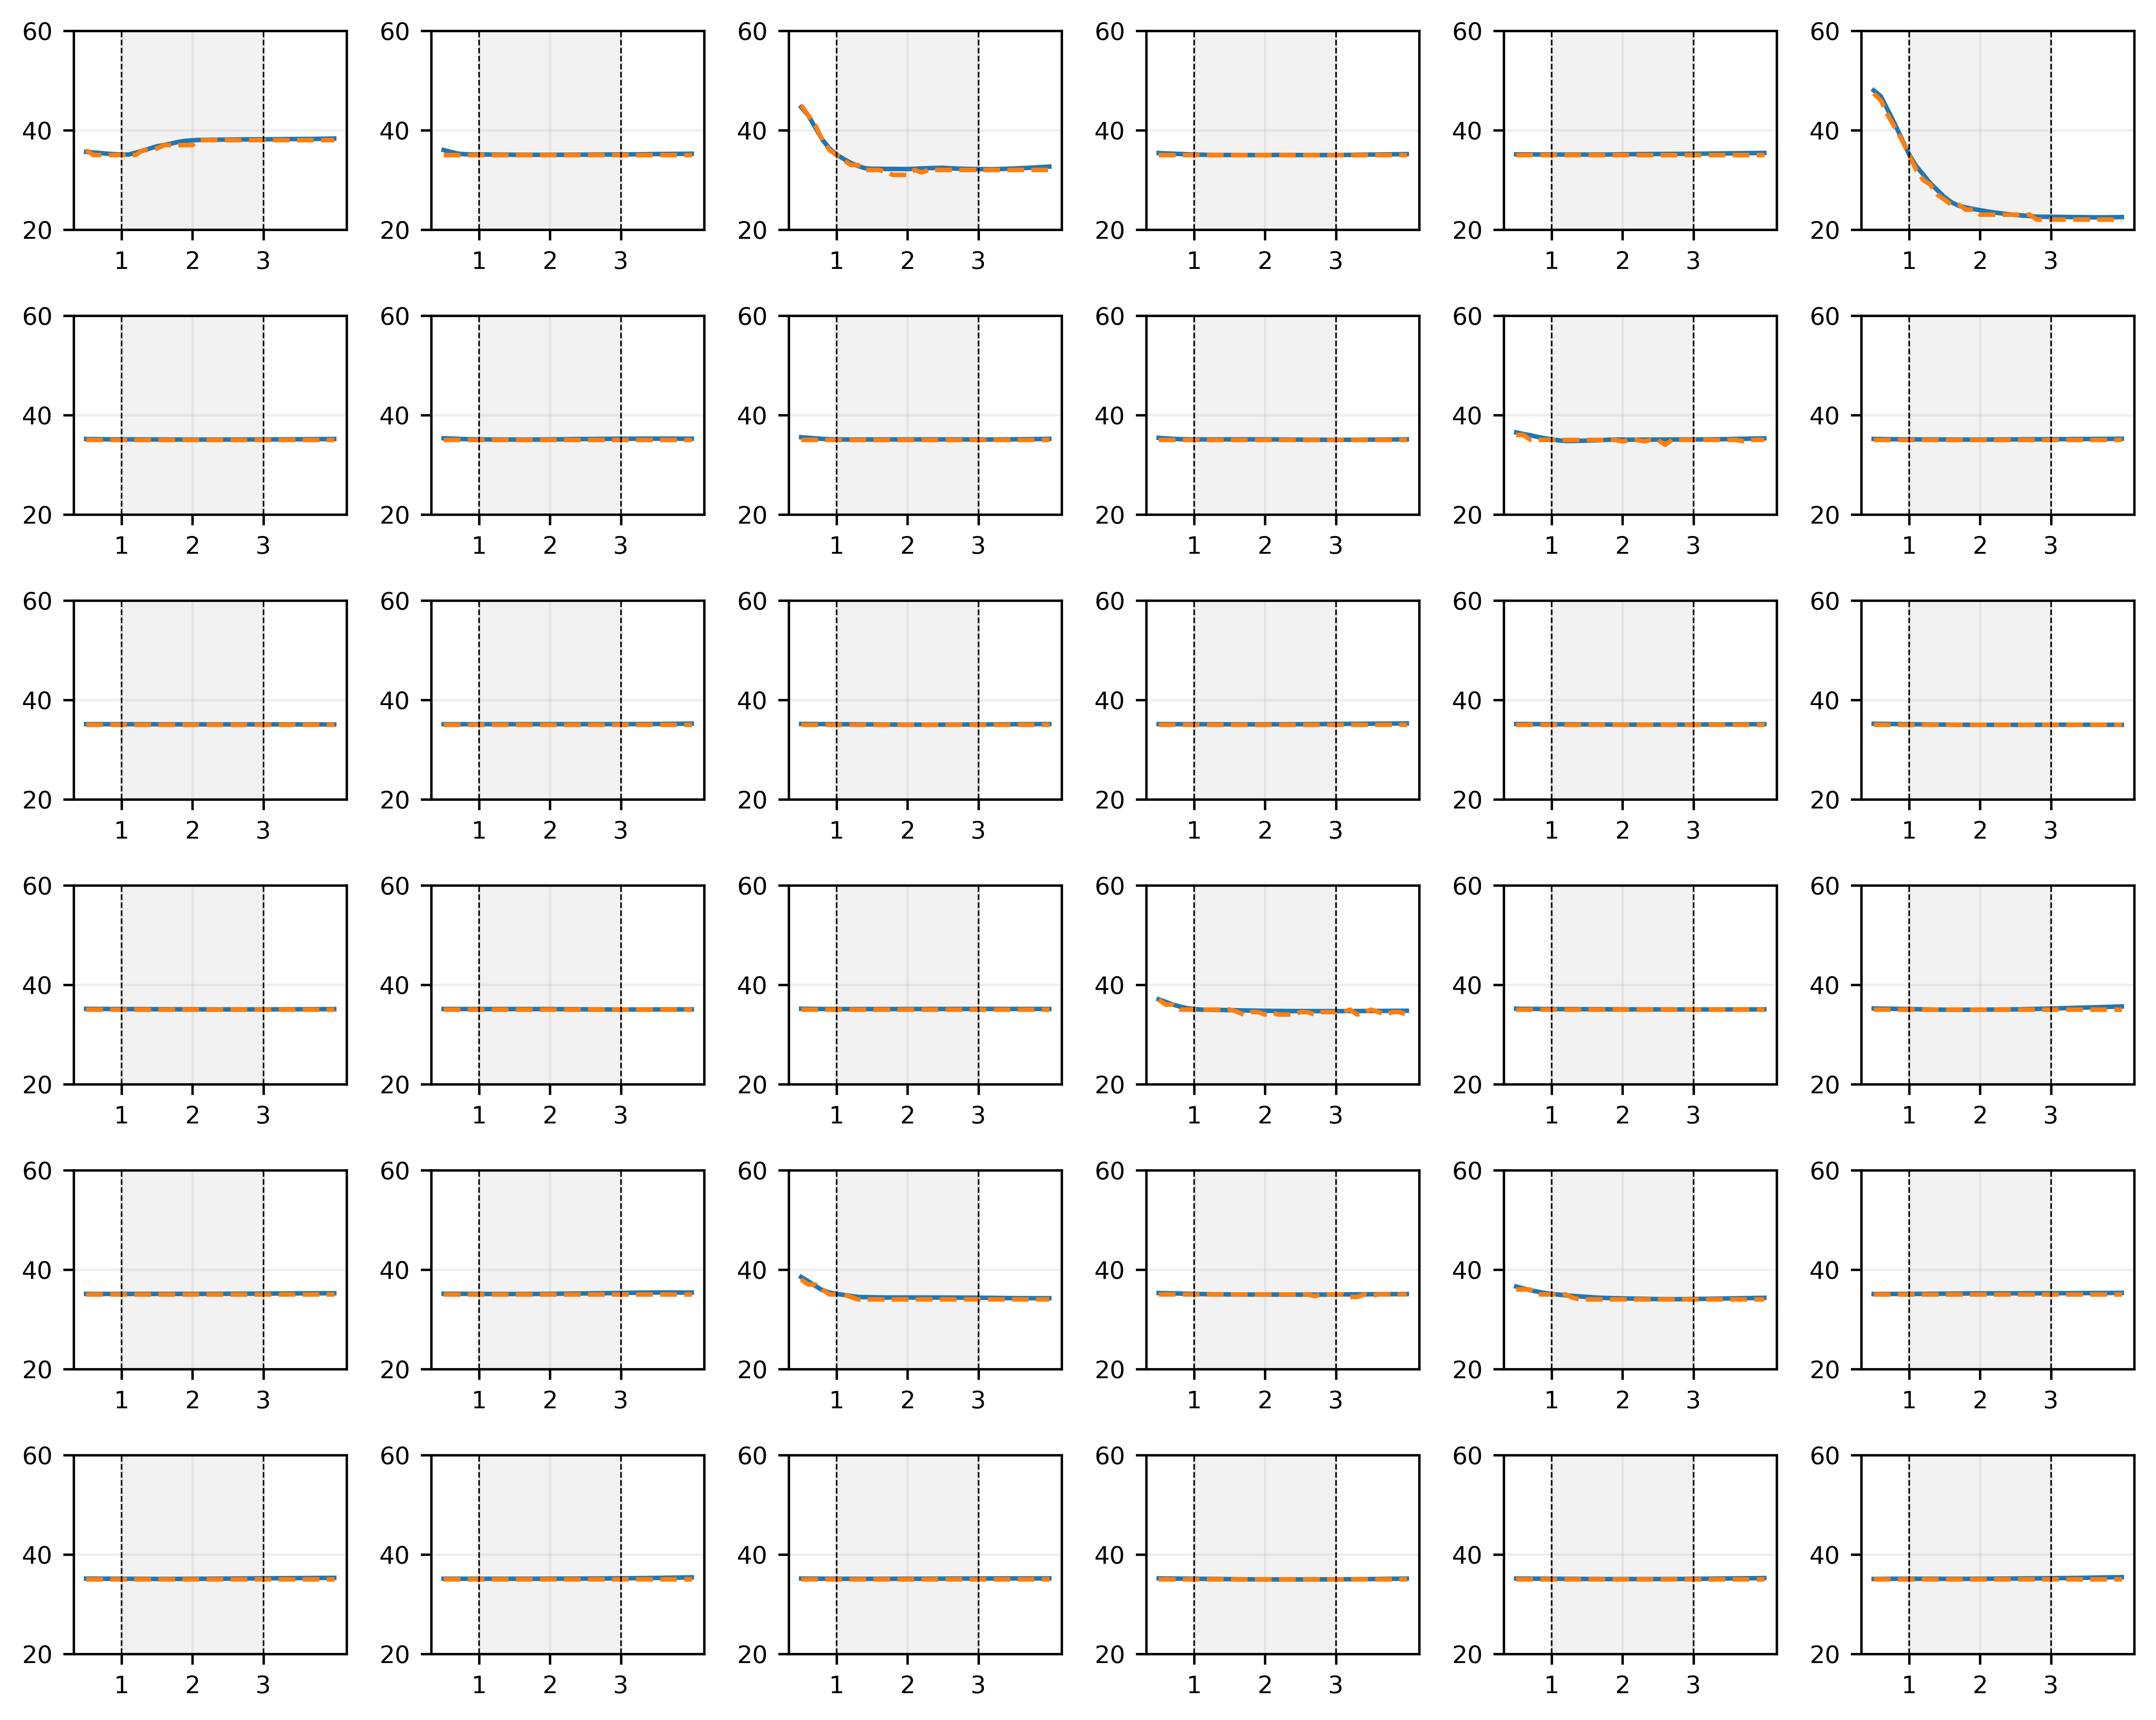

In [75]:
baseline = 43 

plt.figure(figsize=(10, 8), dpi=600) 

n_component = 41

for i in range(n_component-5):
    idx = i + 5
    ax1 = plt.subplot(6,6,i+1)
    cap_increase_domain = np.linspace(0.5, 4.0, num=36)
    plt.plot(cap_increase_domain, sens_matrix[idx,:], label = 'NN')
    plt.plot(cap_increase_domain, sens_matrix_sim[idx,:], linestyle='--', label = 'ATC-138')
    plt.ylim(0.4, 4.1)
    plt.ylim(20, 60)
    plt.grid(alpha=0.2)
    plt.xticks(np.arange(1.0, 4.0, 1.0))
    plt.axvline(x=1.0, linewidth = 0.5, color='k', linestyle='--')
    plt.axvline(x=3.0, linewidth = 0.5,color='k', linestyle='--')
    plt.axvspan(1, 3, alpha=0.1, color='grey')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# plt.legend(loc='lower right')
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"



## Plot OAT system dashboard comparing the performance

In [ ]:
'''Perform sensitivity analysis'''
n_system = 9
n_component = 41
n_increases = 36

t0 = time.time()

sens_matrix_sys = np.zeros((n_system,n_increases))

# Load system control matrix
df_system_contols = pd.read_csv('systemControls.csv', header = None)
system_contols = df_system_contols.to_numpy()


# ''' Example discussed while teaching how to use the code'''

input_to_evaluate = np.ones((1,41))*1.00
input_to_evaluate = scaler.transform(input_to_evaluate)
output_value = mlp.predict(input_to_evaluate)

for i in range(n_system):
        for j in range(n_increases):
                vector_input = np.ones((1,n_component))
                vector_input[0][system_contols[i,:]==1] = 0.5 + j*0.1
                vector_input = scaler.transform(vector_input)
                pred_val = mlp.predict(vector_input)
                sens_matrix_sys[i][j] = pred_val[0]
t1 = time.time()

print(t1-t0)

with open('sensitivity_matrix_sys.pkl','wb') as f:
        pickle.dump(sens_matrix_sys,f)

np.savetxt('sensitivity_matrix_sys.csv',sens_matrix,delimiter=',')



In [ ]:
## Extract OAT system results from file

df_sim_OAAT = pd.read_csv('edgeSys_OAAT_475_0.csv', header = None)
data_sim_OAAT = df_sim_OAAT.to_numpy()

n_sys = 9
n_increases = 36

#preallocate memory for OAAT matrix
sens_matrix_sys_sim = np.zeros((n_sys,n_increases))

for i in range(data_sim_OAAT.shape[0]):
    sys_idx = int(np.floor(i/n_increases))
    cap_idx = int(np.mod(i, n_increases))
    sens_matrix_sys_sim[sys_idx, cap_idx] = data_sim_OAAT[i,-1]    


np.savetxt('sensitivity_matrix_sys_sim.csv',sens_matrix_sys_sim,delimiter=',')





In [ ]:
baseline = 43 

plt.figure(figsize=(10, 8), dpi=600) 

n_system = 9

for i in range(n_system):
    idx = i
    ax1 = plt.subplot(3,3,i+1)
    cap_increase_domain = np.linspace(0.5, 4.0, num=36)
    plt.plot(cap_increase_domain, sens_matrix_sys_sim[idx,:], label = 'ATC-138')
    plt.plot(cap_increase_domain, sens_matrix_sys[idx,:], label = 'NN')
    plt.ylim(0.4, 4.1)
    plt.ylim(10, 60)
    plt.grid(alpha=0.2)
    plt.xticks(np.arange(1.0, 4.0, 1.0))
    plt.axvline(x=1.0, linewidth = 0.5, color='k', linestyle='--')
    plt.axvline(x=3.0, linewidth = 0.5,color='k', linestyle='--')
    plt.axvspan(1, 3, alpha=0.1, color='grey')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# plt.legend(loc='lower right')
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


## Assess component importance

In [216]:
X_test.shape[1] - 7

41

In [218]:
from sklearn.metrics import accuracy_score

# Goal rank each component by R2 value when added or removed from model
X_test = test_data
X_train = train_data

Y_test = test_label
Y_train = train_label
Y_pred = nn_test_label

def get_feature_importance(j, n):
    s = r2_score(Y_test, Y_pred) # baseline score of accuracy
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test.shape[0]))
        X_test_ = X_test.copy()
        X_test_[:, j] = X_test[perm, j]
        X_test_ = (X_test_)
        Y_pred_ = mlp.predict(X_test_)
        s_ij = r2_score(Y_test, Y_pred_)
        total += s_ij
    return s - total / n

        
# Feature importances
imp = []


for j in range(X_test.shape[1]- 7) : # For each of the 41 components
  j = j + 7
    
  f_j = get_feature_importance(j, 100) # For component j, 100 samples 
  print("importance for component " + str(j-7) + " is " + str(f_j))
  imp.append(f_j)
    



importance for component 7 is 6.725975369259451e-05
importance for component 8 is 6.704007748215002e-05
importance for component 9 is 7.674218664088794e-05
importance for component 10 is 0.00022756154186143185
importance for component 11 is 0.0004516200990553054
importance for component 12 is 0.005837939691634264
importance for component 13 is 0.0021697442802558475
importance for component 14 is 0.1756627081327572
importance for component 15 is 0.007586569987816927
importance for component 16 is 8.797302620267011e-06
importance for component 17 is 0.2601464522981428
importance for component 18 is 3.1097113813549626e-05
importance for component 19 is 0.0021148235771462076
importance for component 20 is 0.0020778662213699617
importance for component 21 is 0.0019115958086356466
importance for component 22 is 0.014171156343956048
importance for component 23 is 2.7509631657984812e-05
importance for component 24 is -6.192326310827667e-06
importance for component 25 is 1.7448657162577597e-05


array([False, False, False,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
       False, False, False, False,  True])

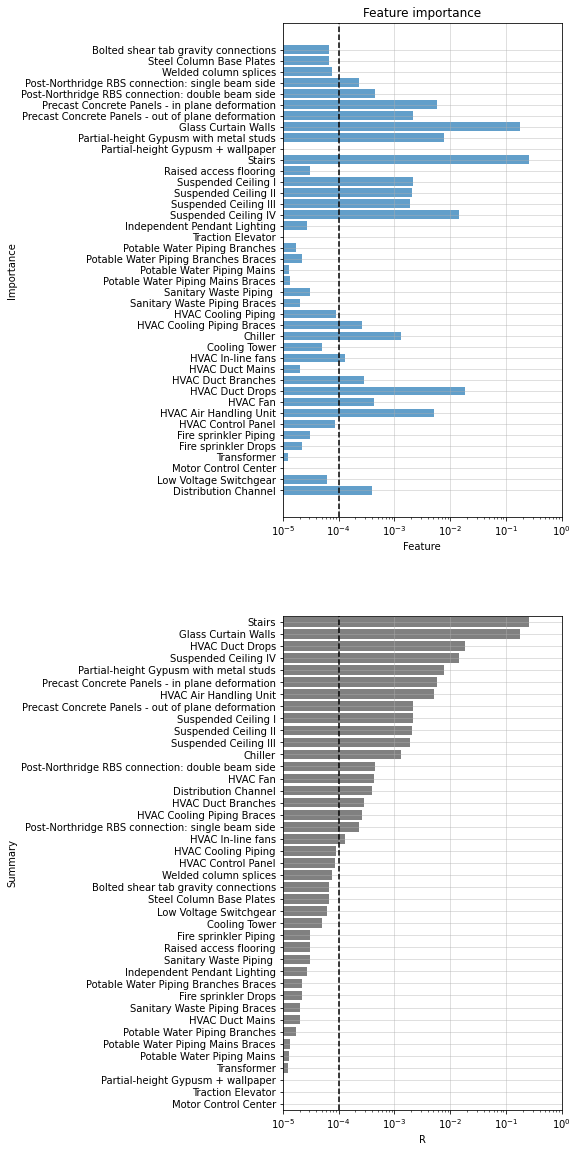

In [321]:
# Plot

# Load performance model: used for component names
pm = pd.read_csv('LowRise_PM_v2.csv')

# Select cuttoff and/or absolute threshold to filter components
# output should be a vector mask that can then be applied during optimization

min_R = 0.00010

# Subplot in order

plt.figure(figsize=(5, 20))

plt.subplot(2, 1, 1)
plt.barh(range(41), np.array(imp), alpha=0.7)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importance")
plt.yticks(ticks=range(41), labels = pm.Summary)
plt.axvline(x=min_R, color='k', linestyle='--')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlim([0.00001, 1])
plt.grid(alpha = 0.5)


plt.subplot(2, 1, 2)
df_imp = pd.DataFrame({'R': np.array(imp)}, index = pm.Summary)
df_imp = df_imp.sort_values('R', axis=0, ascending=False)
b = sns.barplot(x='R', y=df_imp.index, data = df_imp, ci=None, color = 'grey')
plt.axvline(x=min_R, color='k', linestyle='--')
b.set_xscale("log")
plt.xlim([0.00001, 1])
plt.grid(alpha = 0.5)


mask = np.array(imp) > min_R

# mask = mask.reshape(1,-1)

# subplot ranked



mask

### Visualize EDPs

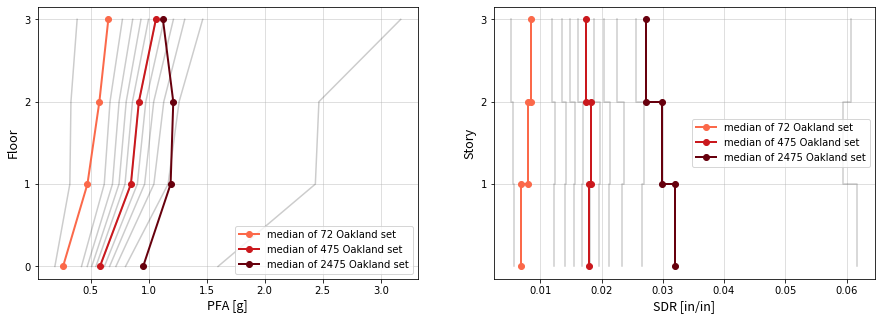

In [76]:
# Load and plot EDP data
import matplotlib.pylab as pl
font = {'fontname':'Source sans pro'}

PFA_data = pd.read_csv('fig_EDP/PFA_set_0_to_100p.csv', index_col = 0)
SDR_data = pd.read_csv('fig_EDP/SDR_set_0_to_100p.csv', index_col = 0)
PFA_med  = pd.read_csv('fig_EDP/medians_PFA.csv', index_col = 0)
SDR_med  = pd.read_csv('fig_EDP/medians_SDR.csv', index_col = 0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
n = 3
colors = pl.cm.Reds(np.linspace(0.5,1,n))
for i in np.arange(11):
    plt.plot(PFA_data.iloc[:,i]/384, np.arange(4), '-', color='k', alpha = 0.2)
for i in np.arange(3):
    plt.plot(PFA_med.iloc[i,:]/384, np.arange(4), '-o', color=colors[i], label = "median of " + str(SDR_med.index[i]) + " Oakland set", linewidth = 2)

plt.grid(alpha = 0.5)
plt.xlabel('PFA [g]',fontsize=14, **font, fontweight='normal')
plt.ylabel('Floor',fontsize=14, **font, fontweight='normal')
plt.yticks(np.arange(0, 4, step=1))
plt.legend()


plt.subplot(1, 2, 2)

for i in np.arange(11):
    plt.step(SDR_data.iloc[:,i], [0, 1, 1, 2, 2, 3], '-', color='k', alpha = 0.2)
for i in np.arange(3):
    plt.plot(SDR_med.iloc[i,:], [0, 1, 1, 2, 2, 3], '-o', color=colors[i], label = "median of " + str(PFA_med.index[i]) + " Oakland set", linewidth = 2)

plt.grid(alpha = 0.5)
plt.yticks(np.arange(1, 4, step=1))
plt.xlabel('SDR [in/in]',fontsize=14, **font, fontweight='normal')
plt.ylabel('Story',fontsize=14, **font, fontweight='normal')
plt.legend()


## Optimization via pymoo

In [24]:
EDP_data = pd.read_csv('EDP_set_0_to_100p.csv', index_col = 0)
EDP_data


,1-PID-1-1,1-PID-2-1,1-PID-3-1,1-PFA-0-1,1-PFA-1-1,1-PFA-2-1,1-PFA-3-1
,,,,,,,
0,0.005635,0.005540,0.005291,74.145,123.670,127.310,147.780
1,0.012288,0.012439,0.011875,162.180,237.459,256.490,297.508
2,0.014022,0.014203,0.013554,181.156,264.568,286.510,331.508
3,0.015439,0.015637,0.014920,195.954,286.260,310.007,358.820
4,0.016750,0.016976,0.016178,209.826,306.090,330.710,383.836
5,0.018092,0.018316,0.017438,223.315,325.660,352.015,408.515
6,0.019552,0.019786,0.018831,237.880,346.910,374.820,435.544
7,0.021191,0.021457,0.020397,255.040,370.953,401.000,466.160
8,0.023354,0.023629,0.022465,275.980,401.612,434.280,503.570


In [324]:
# Import packages
import numpy as np
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.algorithms.soo.nonconvex.ga import GA

class sumXi_constrained(ElementwiseProblem):

    def __init__(self):
        xl = np.concatenate((np.ones((1,5)), np.ones((1,36))*1), axis = None)
        xu = np.concatenate((np.ones((1,5)) * 1.0000000001, np.ones((1,36)) * 3), axis = None)
        super().__init__(n_var=41, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(1,-1)
        out["F"] = np.sum(x) + 10E8*(max( float(mlp.predict(scaler.transform(np.concatenate((edp_input, x), axis = 1)))) - T_target,0 ))**2

        
# Preallocate memory to solution matrix
T_array     = np.arange(14, 7, -1)
EDP_array   = np.arange(4)

sol = np.zeros((len(EDP_array), 41, len(T_array)))
xi  = np.zeros((len(EDP_array), len(T_array)))

n_trial = 2

for edp_idx in EDP_array: 
    for t_idx in np.arange(len(T_array)):
        solution =  np.ones((41, 1)) * 999
        for n in np.arange(n_trial):
            edp_input = np.array([EDP_data.loc[edp_idx]])
            T_target = T_array[t_idx]

            problem = sumXi_constrained()

            algorithm = DE(
                pop_size=41 * 10,
                sampling=LHS(),
                variant="DE/best/1/bin",
                F = 0.8,
                CR = 0.9,
                dither="vector",
                jitter=False
            )
            res = minimize(problem,
                           algorithm,
                           verbose=False)
            if sum(res.X) < sum(solution):
                solution = res.X
        sol[edp_idx][:,t_idx] = solution
        xi[edp_idx ,t_idx]    = sum(solution)
    print("Optimization for " + str(edp_idx) + " EDP decile comprising of "+ str(len(T_array)) + " targets is complete.")


Optimization for 0 EDP decile comprising of 7 targets is complete.
Optimization for 1 EDP decile comprising of 7 targets is complete.
Optimization for 2 EDP decile comprising of 7 targets is complete.
Optimization for 3 EDP decile comprising of 7 targets is complete.


In [207]:
# Save solution in pickle file
# with open('optimum_NN1_fullmodel_10trials_16T.pkl','wb') as f:
#         pickle.dump(sol,f)

## Plot solutions in table format: Fixed EDP, Varying target

[Text(0.5, 0, ''),
 Text(1.5, 0, ''),
 Text(2.5, 0, ''),
 Text(3.5, 0, ''),
 Text(4.5, 0, ''),
 Text(5.5, 0, ''),
 Text(6.5, 0, '')]

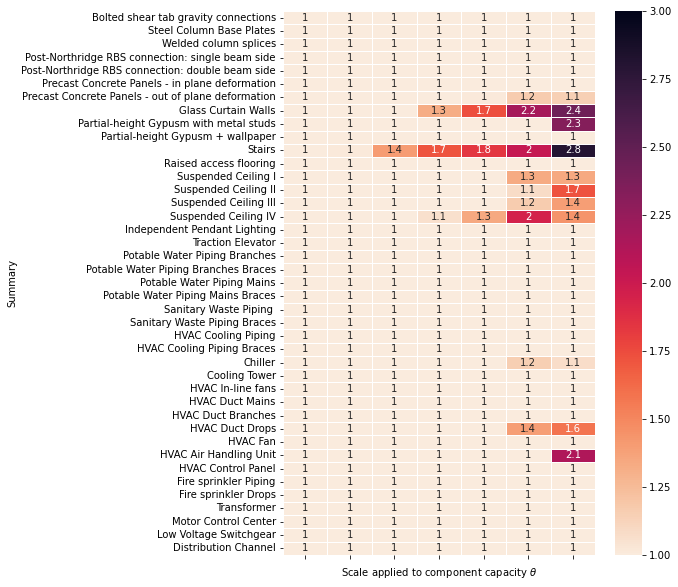

In [373]:
# Load the pre-computed optimum soluion
sol = pickle.load(open('optimum_NN1_fullmodel.pkl','rb'))

T_array     = np.arange(49, 0, -7)
EDP_array   = np.arange(8)

actual = np.array([1.00,1,1,1,1,1,1.5225,1.945,1.6925,1,2.257,1,1.6575,1.2075,1.4,2.0575,1,1,1,1,1.005,1,1,1,1,1.0075,1.76,1,1.005,1,1,1.615,1.2675,1.0975,1,1,1.0025,1,1,1.0075,1])

edp_idx = 6

# sol = sol.reshape((n_run,41))
disp_sol = sol[edp_idx].reshape((len(T_array),41))
actual = actual.reshape((1,41))

# print(np.round(disp_sol,2))
# print(mlp.predict(scaler.transform(sol)))

disp_sol = pd.pandas.DataFrame(disp_sol.reshape(41,len(T_array)))
# disp_avg_sol = np.mean(disp_sol, axis = 1)
# disp_act = pd.pandas.DataFrame(actual.reshape(41,1))

#disp_sol = pd.concat([disp_sol, disp_avg_sol, disp_act], axis=1)

#### Enter return period
return_period = 475
T_target = 14

# Load design data directly from genetic algorithm
data = disp_sol
# data = pd.read_csv('resultsIP_116.csv', header = None, na_values = "NaN")
# data = data[~np.isnan(data.iloc[:,1])] #Removes NaN rows
# data = data.transpose()
# Extract final solution
# optimum = data.iloc[:,-1]
optimum_fragility_mod = data

# Load performance model: used for component names
pm = pd.read_csv('LowRise_PM_v2.csv')

# Add component ID to the beginning of the dataframe
optimum_fragility_mod.index = pm.Summary
optimum_fragility_mod.index.bnames = ['component']
optimum_fragility_mod.columns.names = ['']
optimum_fragility_mod

## Draw a heatmap with the numeric values in each cell
cmap = sns.cm.rocket_r

f, ax = plt.subplots(figsize=(7, 10))
# plt.title('Component enhancements for RP = ' + str(return_period) + 'years at $T_{target} = $' + str(T_target) + ' days', pad = 30)
sns.heatmap(optimum_fragility_mod, annot=True, linewidths=0.5, ax=ax, cmap=cmap, vmin=1, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.xlabel('Scale applied to component capacity ' + r'$ \theta $')
ax.set_xticklabels([])


In [370]:
T_array

array([49, 42, 35, 28, 21, 14,  7])

## Plot solutions in table format: Fixed Target, Varying EDP

[49 42 35 28 21 14  7]


[Text(0.5, 0, ''),
 Text(1.5, 0, ''),
 Text(2.5, 0, ''),
 Text(3.5, 0, ''),
 Text(4.5, 0, ''),
 Text(5.5, 0, ''),
 Text(6.5, 0, ''),
 Text(7.5, 0, '')]

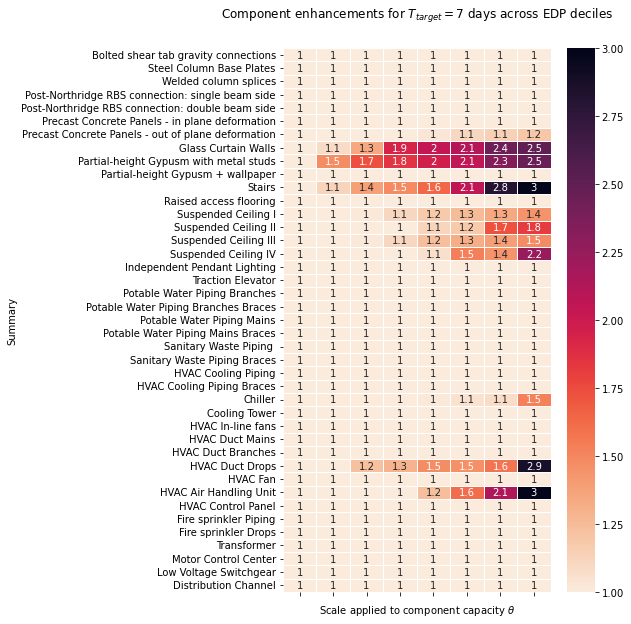

In [362]:
# Load the pre-computed optimum soluion
# sol = pickle.load(open('optimum_NN1_fullmodel_10trials_16T.pkl','rb'))

print(T_array)

T_idx = -1

# Prepopulate array
disp_sol = np.zeros(((41, len(EDP_array))))

for edp in EDP_array:
    disp_sol[:,edp] = sol[edp][:,T_idx]
    
# print(np.round(disp_sol,2))
# print(mlp.predict(scaler.transform(sol)))

disp_sol = pd.pandas.DataFrame(disp_sol)
# disp_avg_sol = np.mean(disp_sol, axis = 1)
# disp_act = pd.pandas.DataFrame(actual.reshape(41,1))

#disp_sol = pd.concat([disp_sol, disp_avg_sol, disp_act], axis=1)

#### Enter return period
return_period = 475
T_target = T_array[T_idx]

# Load design data directly from genetic algorithm
data = disp_sol
# data = pd.read_csv('resultsIP_116.csv', header = None, na_values = "NaN")
# data = data[~np.isnan(data.iloc[:,1])] #Removes NaN rows
# data = data.transpose()
# Extract final solution
# optimum = data.iloc[:,-1]
optimum_fragility_mod = data

# Load performance model: used for component names
pm = pd.read_csv('LowRise_PM_v2.csv')

# Add component ID to the beginning of the dataframe
optimum_fragility_mod.index = pm.Summary
optimum_fragility_mod.index.bnames = ['component']
optimum_fragility_mod.columns.names = ['']
optimum_fragility_mod

## Draw a heatmap with the numeric values in each cell
cmap = sns.cm.rocket_r

f, ax = plt.subplots(figsize=(6, 10))
plt.title('Component enhancements for $T_{target} = $' + str(T_target) + ' days across EDP deciles', pad = 30)
sns.heatmap(optimum_fragility_mod, annot=True, linewidths=0.5, ax=ax, cmap=cmap, vmin=1, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.xlabel('Scale applied to component capacity ' + r'$ \theta $')
ax.set_xticklabels([])



### Plot EDP vs $\Sigma x_i$ heatmap

Text(0.5, 1.0, '# Components required in optimal design')

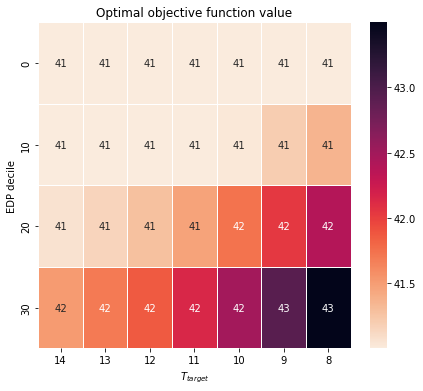

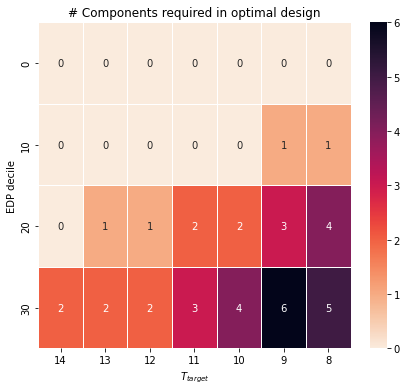

In [329]:
### Count the number of triggered components per solution


# Heatmap of sigma x_i
f, ax = plt.subplots(figsize=(7, 6))

xi_disp = pd.DataFrame(xi)
xi_disp.index.names = ['edp']
xi_disp.columns.names = ['Ttarget']

# Preallocate memory to solution matrix
EDP_perc = EDP_array*10

xi_disp.columns = T_array
xi_disp.index   = EDP_perc

sns.heatmap(xi_disp, linewidths=0.5, annot = True, cmap=cmap)
plt.xlabel('$T_{target}$')
plt.ylabel('EDP decile')
plt.title('Optimal objective function value')


# Heatmap of n_trig
n_trig = np.count_nonzero(sol > 1.1, axis = 1)

f, ax = plt.subplots(figsize=(7, 6))
n_trig_disp = pd.DataFrame(n_trig)
n_trig_disp.index.names = ['edp']
n_trig_disp.columns.names = ['Ttarget']

# Preallocate memory to solution matrix
EDP_perc = EDP_array*10

n_trig_disp.columns = T_array
n_trig_disp.index   = EDP_perc

sns.heatmap(n_trig_disp, linewidths=0.5, annot = True, cmap=cmap)
plt.xlabel('$T_{target}$')
plt.ylabel('EDP decile')
plt.title('# Components required in optimal design')



### Plot $\Sigma x_i$ for multiple EDP intensities


Text(0, 0.5, '$\\Sigma x_{i}$')

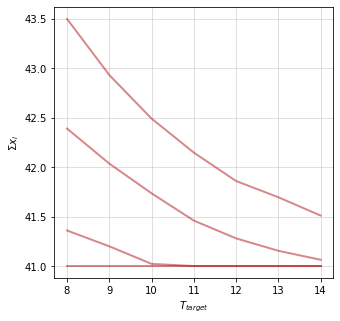

In [330]:
f, ax = plt.subplots(figsize=(5, 5))


EDP_perc = EDP_array * 10

n = len(EDP_array)
colors = pl.cm.Reds(np.linspace(0.5,1,n))
    
for edp_idx in EDP_array: 
    plt.plot(T_array, xi[edp_idx, :], linewidth = 2, color=colors[i], alpha = 0.5)
    plt.grid(alpha = 0.5)
plt.xlabel('$T_{target}$')
plt.ylabel('$\Sigma x_{i}$')

Text(0, 0.5, 'Number of NS components')

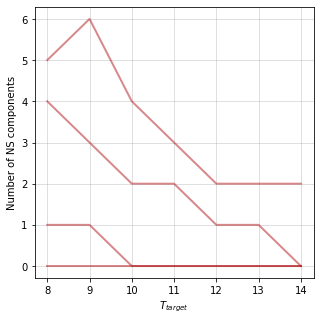

In [340]:
f, ax = plt.subplots(figsize=(5, 5))


EDP_perc = EDP_array * 10

n = len(EDP_array)
colors = pl.cm.Reds(np.linspace(0.5,1,n))
    
for edp_idx in EDP_array: 
    plt.plot(T_array, n_trig[edp_idx, :], linewidth = 2, color=colors[i], alpha = 0.5)
    plt.grid(alpha = 0.5)
plt.xlabel('$T_{target}$')
plt.ylabel('Number of NS components')



(1.0, 3.0)

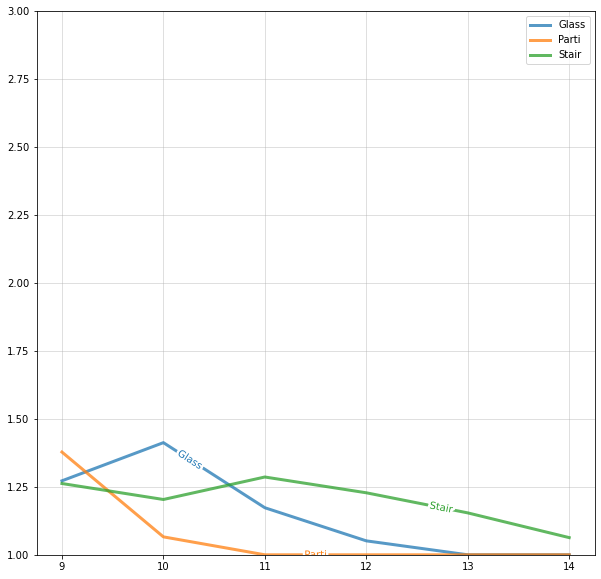

In [346]:
f, ax = plt.subplots(figsize=(10, 10))

from labellines import labelLine, labelLines

EDP_perc = EDP_array * 10

n = len(EDP_array)
colors = pl.cm.Reds(np.linspace(0.5,1,n))

edp_idx = 2

for comp in np.arange(41):
    if(max(sol[edp_idx][comp,:-1]) > 1.1):
        plt.plot(T_array[:-1], sol[edp_idx][comp,:-1], linewidth = 3, alpha = 0.75, label =  pm.Summary[comp][0:5])

plt.grid(alpha = 0.5)
plt.legend()
labelLines(plt.gca().get_lines(),zorder=2.5)
plt.ylim([1, 3])



[14 13 12 11 10  9  8]


(1.0, 3.0)

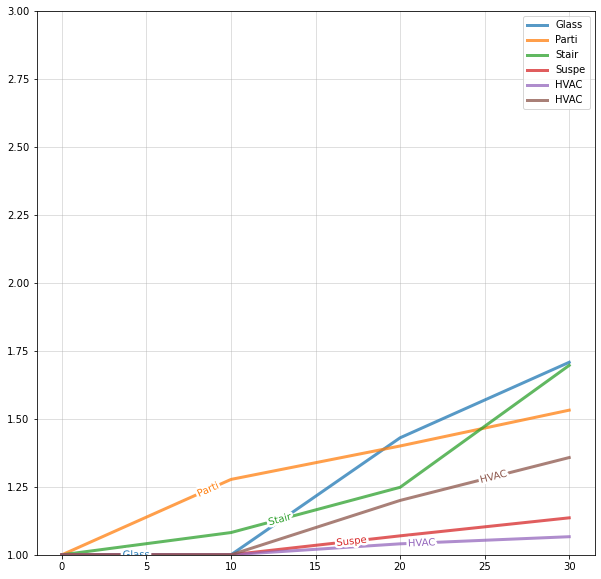

In [343]:
f, ax = plt.subplots(figsize=(10, 10))

from labellines import labelLine, labelLines


print(T_array)

T_idx = -1

EDP_perc = EDP_array * 10

# Prepopulate array
disp_sol = np.zeros(((41, len(EDP_array))))

for edp in EDP_array:
    disp_sol[:,edp] = sol[edp][:,T_idx]

for comp in np.arange(41):
    if(max(sol[edp_idx][comp,:-1]) > 1.1):
        plt.plot(EDP_perc, disp_sol[comp,:], linewidth = 3, alpha = 0.75, label =  pm.Summary[comp][0:5])

plt.grid(alpha = 0.5)
plt.legend()
labelLines(plt.gca().get_lines(),zorder=2.5)
plt.ylim([1, 3])




In [ ]:
## Plot the 